### Import necessary packages

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import lightgbm as lgb
import shap

In [22]:
shap.initjs() # initialising SHAP javascript module for js-based notebook viz in SHAP

### German Credit Dataset 

In [23]:
data = pd.read_csv('data/german_credit_data.csv', index_col=0)

data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


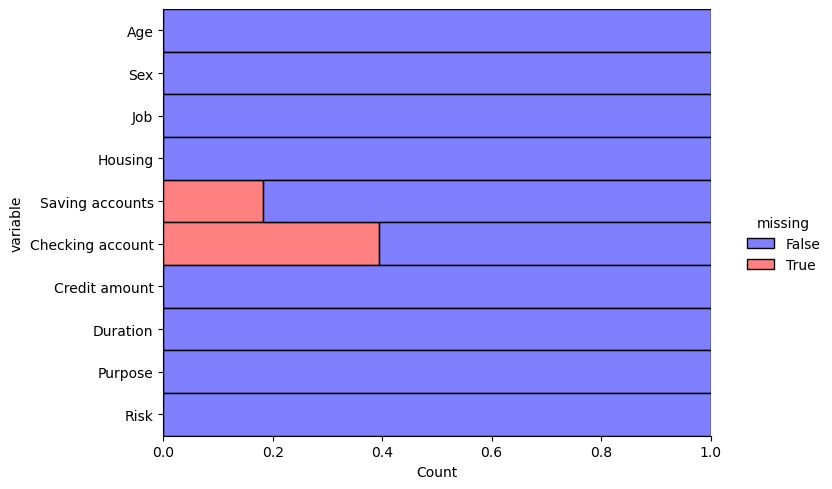

In [24]:
from matplotlib import pyplot as plt 

# Visualise missing data
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5,
    palette="seismic"
)

plt.show()

In [25]:
data.fillna('unknown', inplace = True)

In [26]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,unknown,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,unknown,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() # use label encoder to turn string-like feature into integer format

columns = list(data.columns) # get all columns

for column in columns:
    if type(data[column].iloc[0]) == str: # check that the column value is of type 'str'
        le.fit(data[column]) # transform to 'int'
        data[column] = le.transform(data[column]) # and replace

In [28]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,4,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,3,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


In [30]:
# TODO: feature engineering, outlier detection, data normalisation for efficient ML model. 

from sklearn.model_selection import train_test_split

features = data.drop("Risk", axis = 1)
labels = data["Risk"]

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42) # split into 80% training set and 20% testing set

In [32]:
cat_features = list(features.columns)

data_train = lgb.Dataset(x_train, label=y_train, categorical_feature = cat_features)
data_test = lgb.Dataset(x_test, label=y_test, categorical_feature=cat_features)

In [36]:
params = {
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'auc',
    'num_leaves' : 20,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq' : 5,
    'verbose' : -1,
    'lambda_l1' : 1,
    'lambda_l2' : 1,
    'seed' : 41
}

In [37]:
model = lgb.train(params, data_train, num_boost_round=100, verbose_eval=100, valid_sets=[data_test, data_train])

[100]	training's auc: 0.819832	valid_0's auc: 0.728032


categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.


### Apply TreeExplainer from SHAP

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


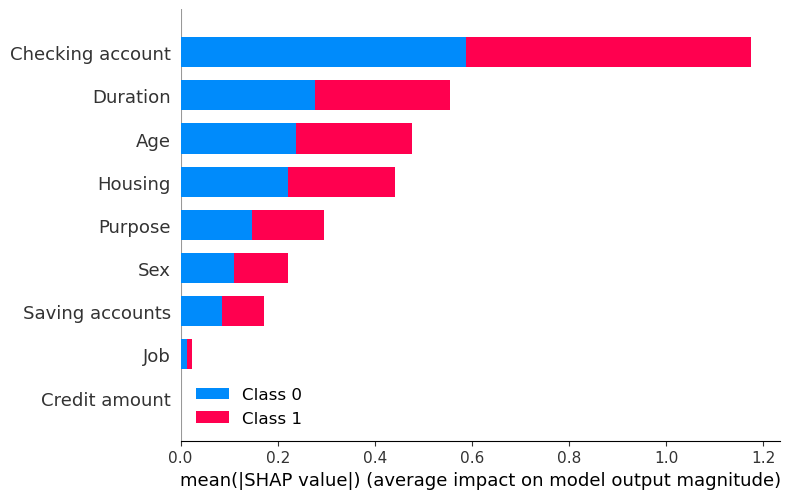

In [46]:
shap.summary_plot(shap_values, x_test)

In [54]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features.iloc[0,:])


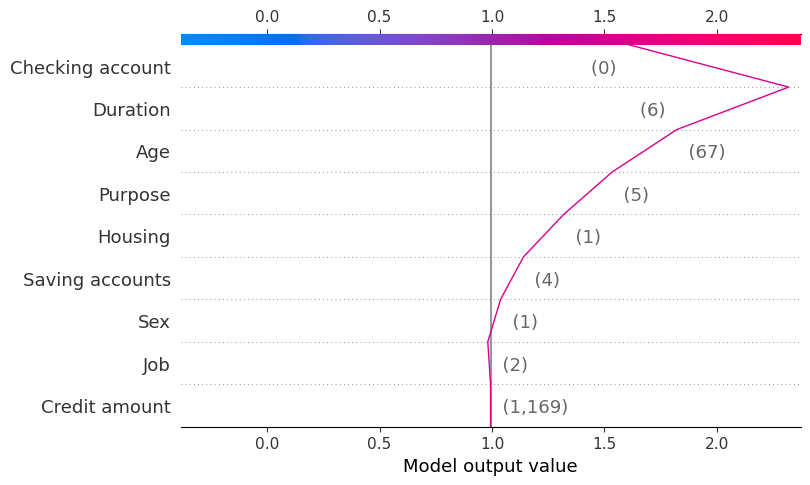

In [55]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], features.iloc[0,:])

Feature Dependence plot for: Purpose


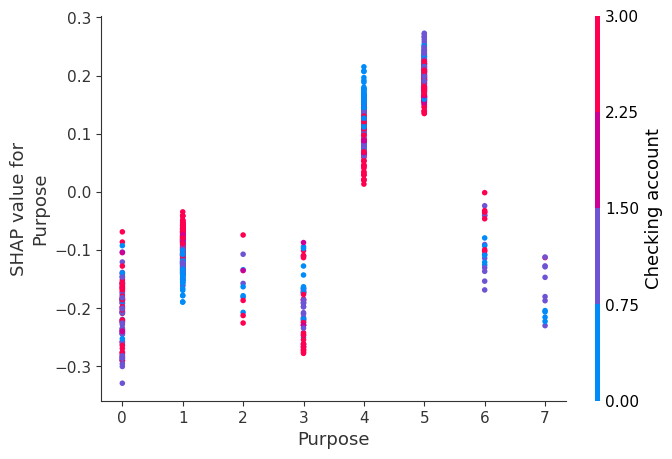

Feature Dependence plot for: Age


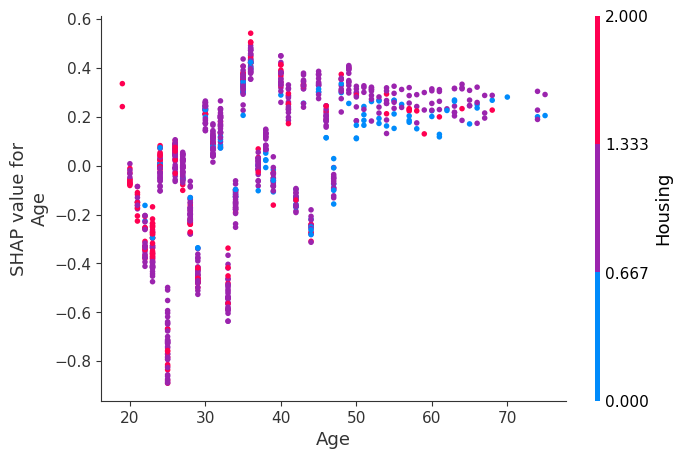

In [56]:
for column in ['Purpose', 'Age']:
    print(f"Feature Dependence plot for: {column}")

    shap.dependence_plot(column, shap_values[1], features, display_features=features)